<a href="https://colab.research.google.com/github/suhas-iyer-au7/Flight_delay_Prediction/blob/main/Flight_Delay_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="30">Predicting On-Time Performance (OTP) of Flights-</font>

### Buisness Goal
Predict flight delays (>15 minutes) to enable proactive resource management and improve operational efficiency.

## Key Dataset Insights:
12,311 flight records with 25% delay rate (3,073 delayed flights)

Significant regional variation: CIS routes have 41.4% delay rate vs GCC at 18.7%

Terminal 3 shows 37.6% delays vs Terminal 2 at 20.5%

## Evaluation Metrics
Business-Focused Metrics:
Precision: Minimize false alarms (manage resource allocation)

Recall: Catch actual delays (prioritize high-risk flights, and mitigate delays)


## **Importing Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score,
                           confusion_matrix, roc_curve)
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('/content/Flight_Delay_Case_Sample_Data.xlsx')

## **Initial Data Exploration and EDA**

In [4]:

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


print("=" * 60)
print("FLYABC FLIGHT DELAY ANALYSIS")
print("=" * 60)

# Basic dataset information
print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"info: {df.info()}")


FLYABC FLIGHT DELAY ANALYSIS

Dataset Shape: (12311, 19)
Columns: ['Flight_ID', 'departure date', 'parking_bay', 'sch_departure_lt', 'sch_departure_utc', 'from_airport', 'to_airport', 'to_Region', 'terminal', 'gate_number', 'flight_minutes', 'booked_passengers', 'flt_capacity', 'prev_Airport', 'prev_flight_arrival', 'total_number_of_bags', 'distance', 'delay', 'aircraft']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12311 entries, 0 to 12310
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Flight_ID             12311 non-null  object        
 1   departure date        12311 non-null  datetime64[ns]
 2   parking_bay           12311 non-null  object        
 3   sch_departure_lt      12311 non-null  datetime64[ns]
 4   sch_departure_utc     12311 non-null  datetime64[ns]
 5   from_airport          12311 non-null  object        
 6   to_airport            12311 non-null  object   

In [5]:

# ===================================================================
# 1. DATA OVERVIEW AND BASIC STATISTICS
# ===================================================================

print("\n" + "=" * 60)
print("1. DATA OVERVIEW")
print("=" * 60)

# Target variable analysis
df['is_delayed'] = (df['delay'] > 15).astype(int)


print(f"Total flights: {len(df):,}")
print(f"Delayed flights (>15 min): {df['is_delayed'].sum():,} ({df['is_delayed'].mean()*100:.1f}%)")
print(f"On-time flights: {(~df['is_delayed'].astype(bool)).sum():,} ({(1-df['is_delayed'].mean())*100:.1f}%)")
print(f"\nDelay Statistics:")
print(f"  Mean delay: {df['delay'].mean():.1f} minutes")
print(f"  Median delay: {df['delay'].median():.1f} minutes")
print(f"  Max delay: {df['delay'].max():.0f} minutes")
print(f"  Standard deviation: {df['delay'].std():.1f} minutes")

# Check for missing values
print(f"\nMissing Values:")
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
if len(missing_data) > 0:
    for col, count in missing_data.items():
        print(f"  {col}: {count} ({count/len(df)*100:.4f}%)")
else:
    print("  No missing values found")


1. DATA OVERVIEW
Total flights: 12,311
Delayed flights (>15 min): 3,073 (25.0%)
On-time flights: 9,238 (75.0%)

Delay Statistics:
  Mean delay: 12.2 minutes
  Median delay: 6.0 minutes
  Max delay: 668 minutes
  Standard deviation: 22.3 minutes

Missing Values:
  terminal: 5 (0.0406%)


## **Here we can see that 75% of the Flights are on time and 25% are delayed**

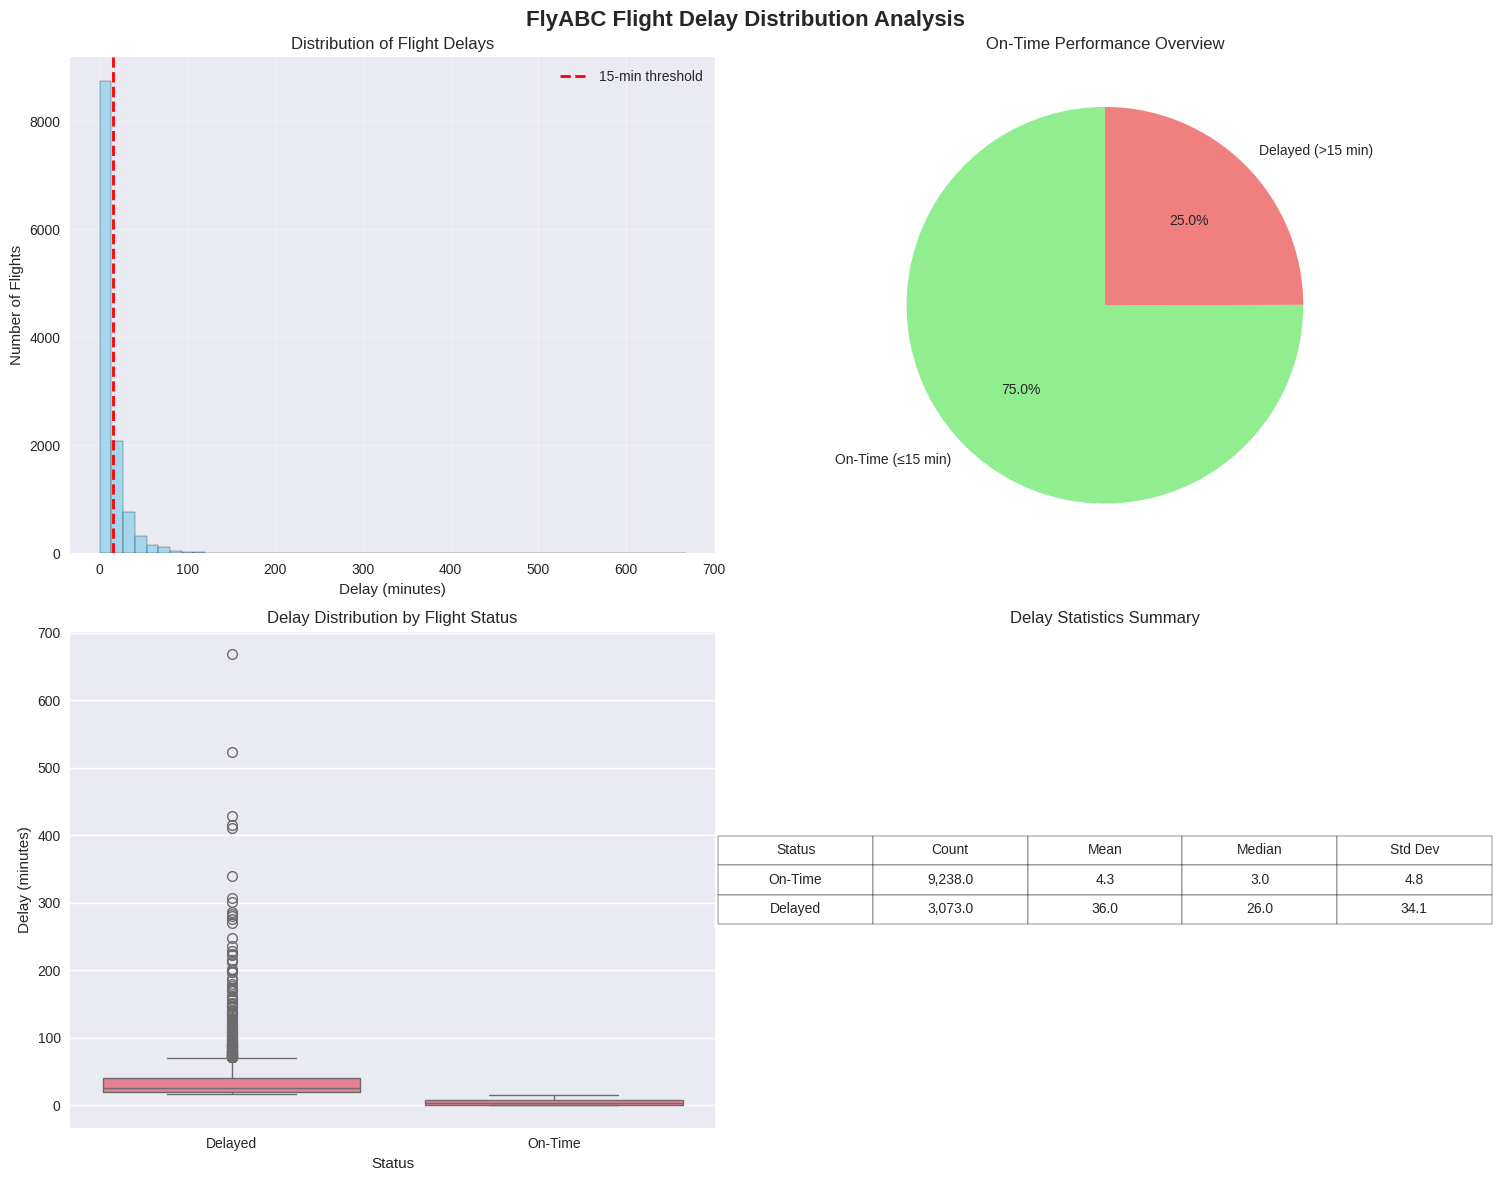

In [12]:


# ===================================================================
# 2. VISUALIZATION 1: OVERALL DELAY DISTRIBUTION
# ===================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('FlyABC Flight Delay Distribution Analysis', fontsize=16, fontweight='bold')

# Subplot 1: Delay histogram
axes[0,0].hist(df['delay'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0,0].axvline(15, color='red', linestyle='--', linewidth=2, label='15-min threshold')
axes[0,0].set_xlabel('Delay (minutes)')
axes[0,0].set_ylabel('Number of Flights')
axes[0,0].set_title('Distribution of Flight Delays')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Subplot 2: On-time vs Delayed pie chart
delay_counts = df['is_delayed'].value_counts()
labels = ['On-Time (≤15 min)', 'Delayed (>15 min)']
colors = ['lightgreen', 'lightcoral']
axes[0,1].pie(delay_counts.values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0,1].set_title('On-Time Performance Overview')

# Subplot 3: Box plot of delays by delayed/on-time
df_plot = df.copy()
df_plot['Status'] = df_plot['is_delayed'].map({0: 'On-Time', 1: 'Delayed'})
sns.boxplot(data=df_plot, x='Status', y='delay', ax=axes[1,0])
axes[1,0].set_title('Delay Distribution by Flight Status')
axes[1,0].set_ylabel('Delay (minutes)')

# Subplot 4: Delay statistics summary
delay_stats = df.groupby('is_delayed')['delay'].agg(['count', 'mean', 'median', 'std']).round(1)
delay_stats.index = ['On-Time', 'Delayed']
axes[1,1].axis('tight')
axes[1,1].axis('off')
table_data = []
for idx, row in delay_stats.iterrows():
    table_data.append([idx, f"{row['count']:,}", f"{row['mean']:.1f}", f"{row['median']:.1f}", f"{row['std']:.1f}"])

table = axes[1,1].table(cellText=table_data,
                       colLabels=['Status', 'Count', 'Mean', 'Median', 'Std Dev'],
                       cellLoc='center',
                       loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1,1].set_title('Delay Statistics Summary')

plt.tight_layout()
plt.show()

## **Looking at Region wise split, we can conclude that flights to CIS region experience most delays**


2. REGIONAL PERFORMANCE ANALYSIS
Regional Performance Summary:
           Total_Flights  Delay_Rate_Pct  Avg_Delay
to_Region                                          
CIS                 1711            41.0      18.33
AF                  1198            32.0      14.70
EU                  3266            26.0      12.14
GCC                 4289            19.0       9.99
ME                  1847            19.0      10.13


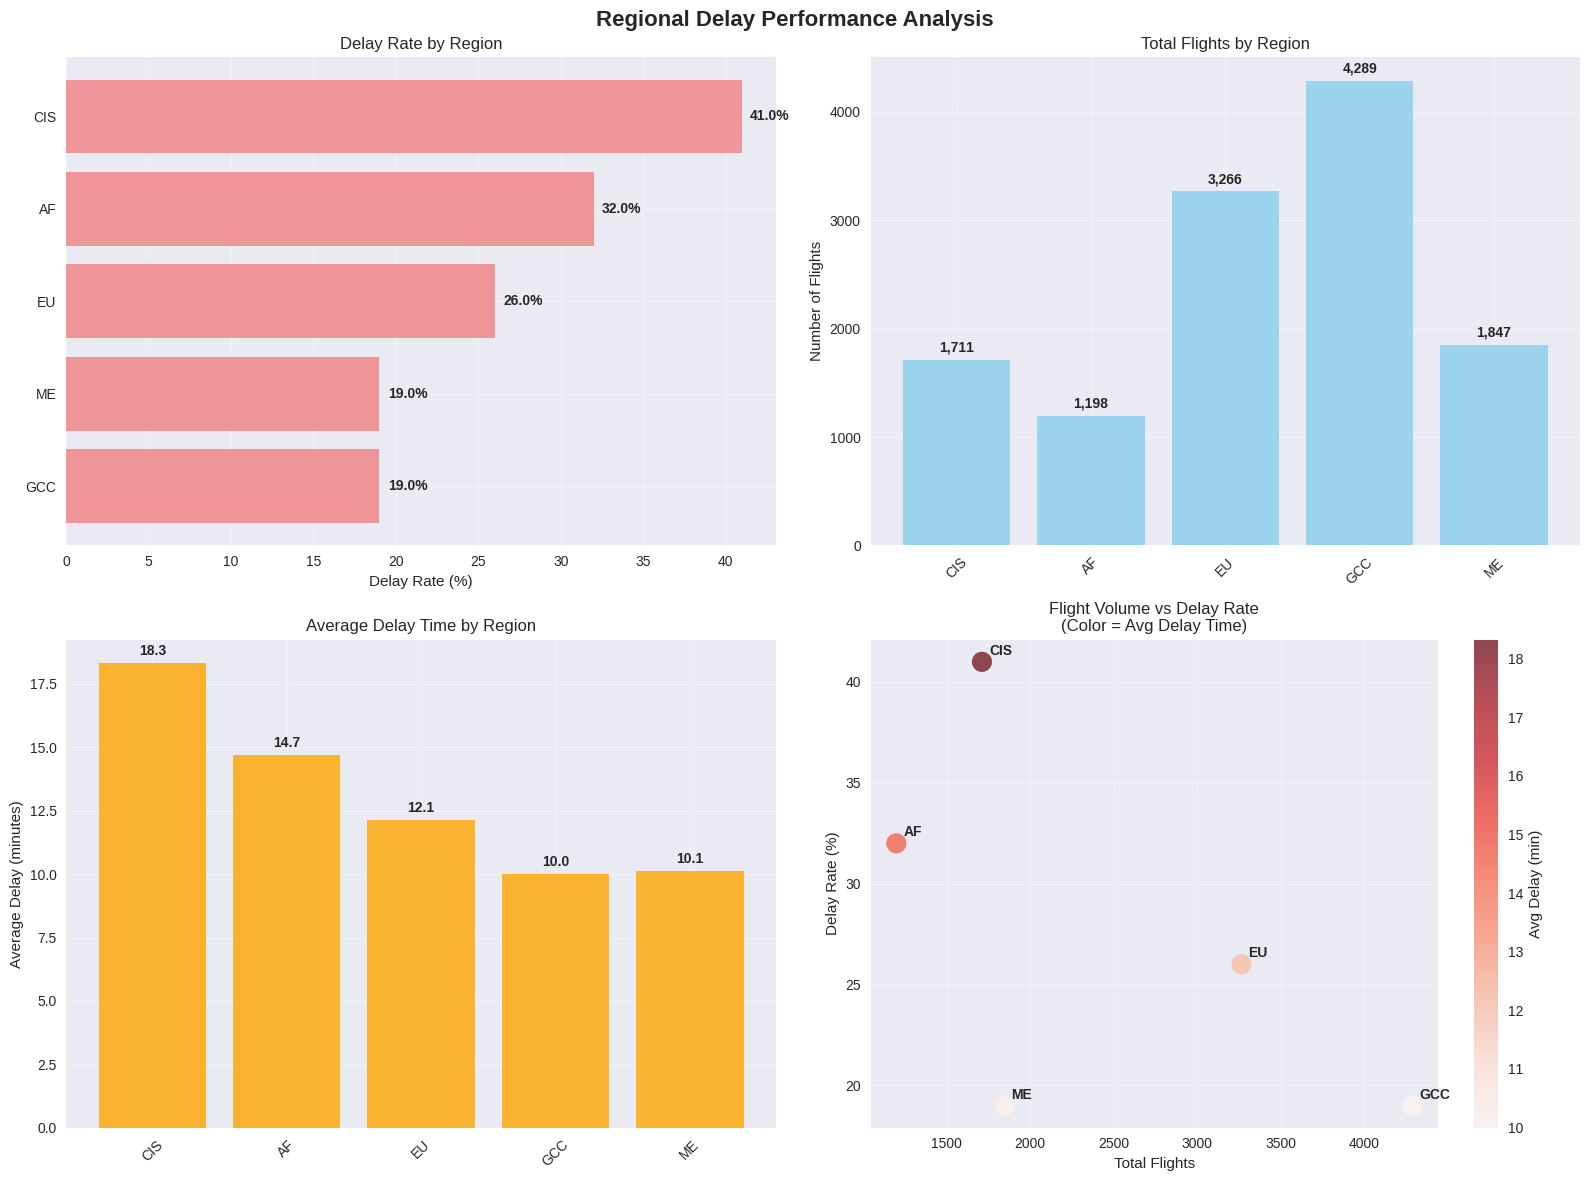

In [14]:

# ===================================================================
# 3. REGIONAL ANALYSIS
# ===================================================================

print("\n" + "=" * 60)
print("2. REGIONAL PERFORMANCE ANALYSIS")
print("=" * 60)

# Calculate regional statistics
regional_stats = df.groupby('to_Region').agg({
    'Flight_ID': 'count',
    'delay': ['mean', 'median'],
    'is_delayed': ['sum', 'mean']
}).round(2)

regional_stats.columns = ['Total_Flights', 'Avg_Delay', 'Median_Delay', 'Delayed_Count', 'Delay_Rate']
regional_stats['Delay_Rate_Pct'] = regional_stats['Delay_Rate'] * 100
regional_stats = regional_stats.sort_values('Delay_Rate_Pct', ascending=False)

print("Regional Performance Summary:")
print(regional_stats[['Total_Flights', 'Delay_Rate_Pct', 'Avg_Delay']].to_string())

# Regional visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Regional Delay Performance Analysis', fontsize=16, fontweight='bold')

# Subplot 1: Delay rate by region
regional_stats_sorted = regional_stats.sort_values('Delay_Rate_Pct', ascending=True)
bars1 = axes[0,0].barh(regional_stats_sorted.index, regional_stats_sorted['Delay_Rate_Pct'],
                       color='lightcoral', alpha=0.8)
axes[0,0].set_xlabel('Delay Rate (%)')
axes[0,0].set_title('Delay Rate by Region')
axes[0,0].grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    width = bar.get_width()
    axes[0,0].text(width + 0.5, bar.get_y() + bar.get_height()/2,
                   f'{width:.1f}%', ha='left', va='center', fontweight='bold')

# Subplot 2: Total flights by region
bars2 = axes[0,1].bar(regional_stats.index, regional_stats['Total_Flights'],
                      color='skyblue', alpha=0.8)
axes[0,1].set_ylabel('Number of Flights')
axes[0,1].set_title('Total Flights by Region')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 50,
                   f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

# Subplot 3: Average delay by region
bars3 = axes[1,0].bar(regional_stats.index, regional_stats['Avg_Delay'],
                      color='orange', alpha=0.8)
axes[1,0].set_ylabel('Average Delay (minutes)')
axes[1,0].set_title('Average Delay Time by Region')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.2,
                   f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# Subplot 4: Scatter plot - Flights vs Delay Rate
scatter = axes[1,1].scatter(regional_stats['Total_Flights'], regional_stats['Delay_Rate_Pct'],
                           s=200, alpha=0.7, c=regional_stats['Avg_Delay'], cmap='Reds')
axes[1,1].set_xlabel('Total Flights')
axes[1,1].set_ylabel('Delay Rate (%)')
axes[1,1].set_title('Flight Volume vs Delay Rate\n(Color = Avg Delay Time)')
axes[1,1].grid(True, alpha=0.3)

# Add region labels to scatter points
for idx, row in regional_stats.iterrows():
    axes[1,1].annotate(idx, (row['Total_Flights'], row['Delay_Rate_Pct']),
                      xytext=(5, 5), textcoords='offset points', fontweight='bold')

# Add colorbar
plt.colorbar(scatter, ax=axes[1,1], label='Avg Delay (min)')

plt.tight_layout()
plt.show()

## **By looking at the operational factors we can see that Terminal and Capacity Utilization Play key role in affecting delays**


3. OPERATIONAL FACTORS ANALYSIS
Terminal Performance:
            Total_Flights  Avg_Delay  Delay_Rate  Delay_Rate_Pct
terminal                                                        
Terminal 2           9106      10.57        0.21            21.0
Terminal 3           3200      16.82        0.38            38.0

Aircraft Type Performance:
            Total_Flights  Avg_Delay  Delay_Rate  Delay_Rate_Pct
aircraft                                                        
B737 MAX 8           8136      12.73        0.27            27.0
B737 MAX 9            259      13.27        0.27            27.0
B737-800             3916      11.02        0.21            21.0

Capacity Utilization vs Delays:
                    Total_Flights  Avg_Delay  Delay_Rate  Delay_Rate_Pct
utilization_bucket                                                      
Low (<70%)                   4013       8.58        0.16            16.0
Medium (70-90%)              3286      12.07        0.25            25.0
High (>

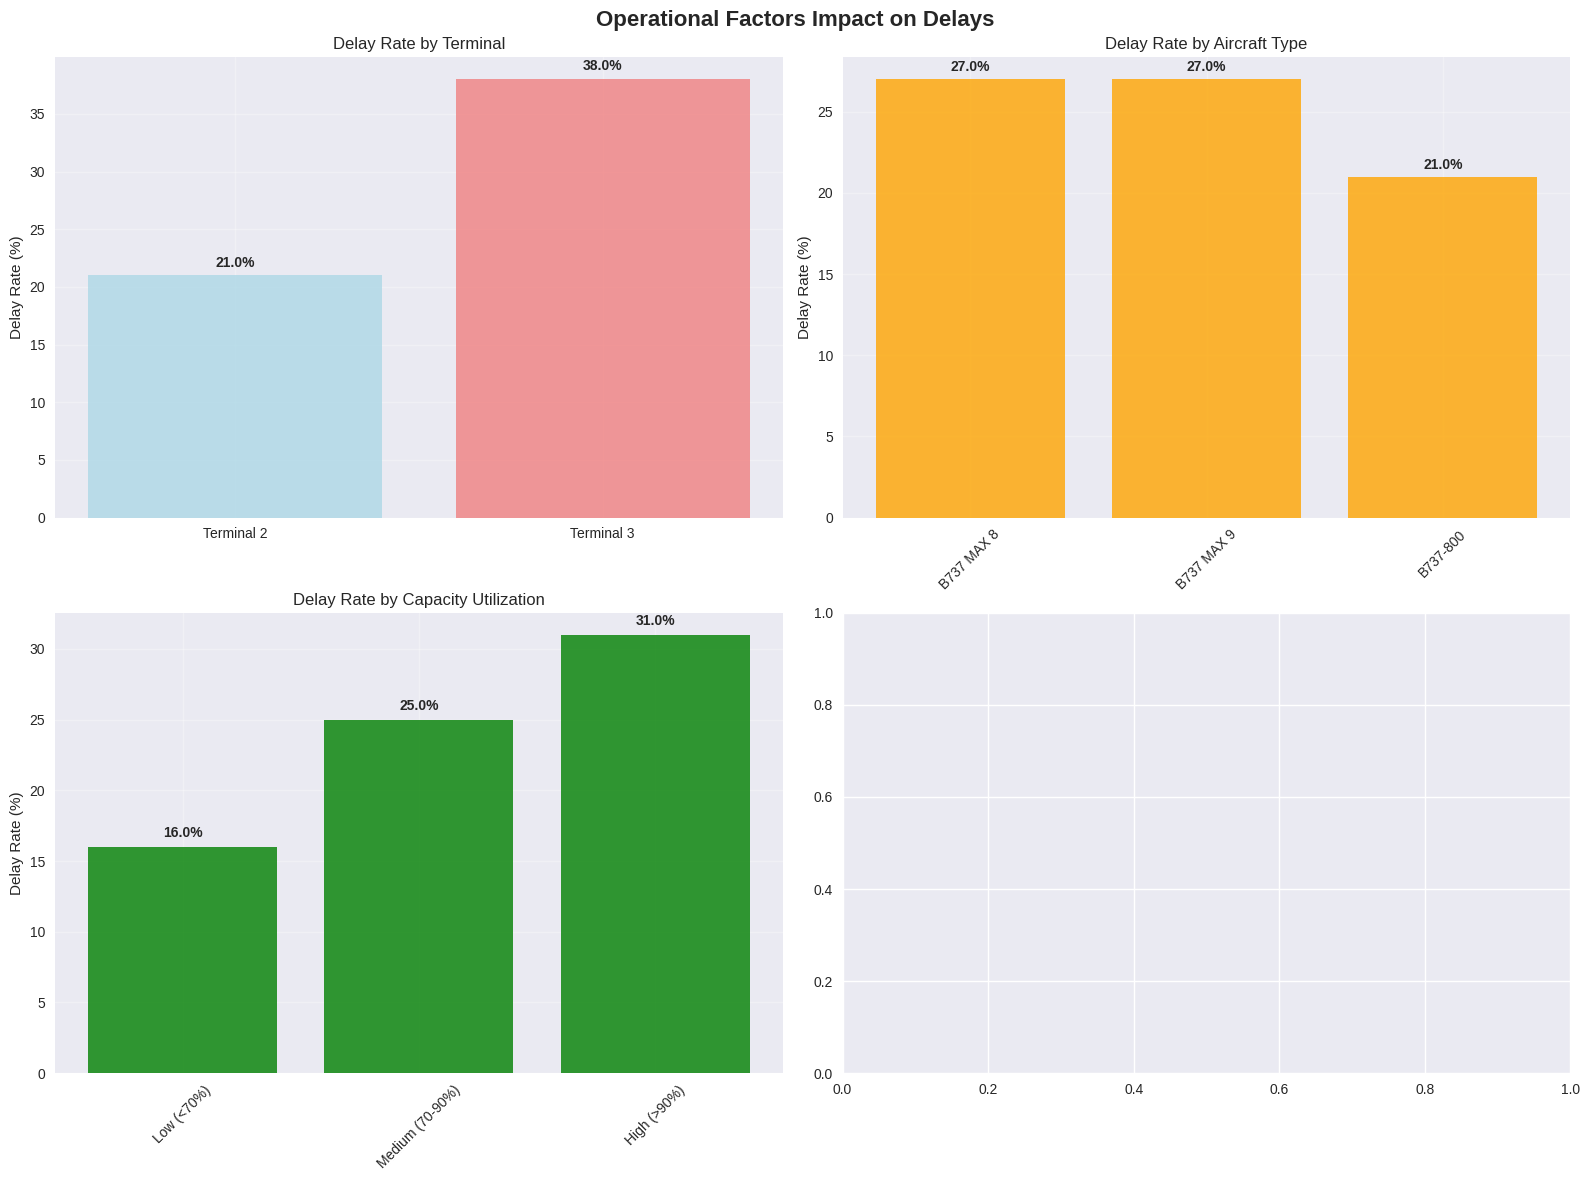

In [15]:
# ===================================================================
# 4. OPERATIONAL FACTORS ANALYSIS
# ===================================================================

print("\n" + "=" * 60)
print("3. OPERATIONAL FACTORS ANALYSIS")
print("=" * 60)

# Terminal analysis
terminal_stats = df.groupby('terminal').agg({
    'Flight_ID': 'count',
    'delay': 'mean',
    'is_delayed': 'mean'
}).round(2)
terminal_stats.columns = ['Total_Flights', 'Avg_Delay', 'Delay_Rate']
terminal_stats['Delay_Rate_Pct'] = terminal_stats['Delay_Rate'] * 100

print("Terminal Performance:")
print(terminal_stats.to_string())

# Aircraft analysis
aircraft_stats = df.groupby('aircraft').agg({
    'Flight_ID': 'count',
    'delay': 'mean',
    'is_delayed': 'mean'
}).round(2)
aircraft_stats.columns = ['Total_Flights', 'Avg_Delay', 'Delay_Rate']
aircraft_stats['Delay_Rate_Pct'] = aircraft_stats['Delay_Rate'] * 100

print("\nAircraft Type Performance:")
print(aircraft_stats.to_string())

# Capacity utilization analysis
df['load_factor'] = df['booked_passengers'] / df['flt_capacity']
df['utilization_bucket'] = pd.cut(df['load_factor'],
                                 bins=[0, 0.7, 0.9, 1.0],
                                 labels=['Low (<70%)', 'Medium (70-90%)', 'High (>90%)'])

utilization_stats = df.groupby('utilization_bucket').agg({
    'Flight_ID': 'count',
    'delay': 'mean',
    'is_delayed': 'mean'
}).round(2)
utilization_stats.columns = ['Total_Flights', 'Avg_Delay', 'Delay_Rate']
utilization_stats['Delay_Rate_Pct'] = utilization_stats['Delay_Rate'] * 100

print("\nCapacity Utilization vs Delays:")
print(utilization_stats.to_string())

# Operational factors visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Operational Factors Impact on Delays', fontsize=16, fontweight='bold')

# Terminal comparison
terminal_stats_clean = terminal_stats.dropna()
bars1 = axes[0,0].bar(terminal_stats_clean.index, terminal_stats_clean['Delay_Rate_Pct'],
                      color=['lightblue', 'lightcoral'], alpha=0.8)
axes[0,0].set_ylabel('Delay Rate (%)')
axes[0,0].set_title('Delay Rate by Terminal')
axes[0,0].grid(True, alpha=0.3)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Aircraft type comparison
bars2 = axes[0,1].bar(aircraft_stats.index, aircraft_stats['Delay_Rate_Pct'],
                      color='orange', alpha=0.8)
axes[0,1].set_ylabel('Delay Rate (%)')
axes[0,1].set_title('Delay Rate by Aircraft Type')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.3,
                   f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Capacity utilization
bars3 = axes[1,0].bar(utilization_stats.index, utilization_stats['Delay_Rate_Pct'],
                      color='green', alpha=0.8)
axes[1,0].set_ylabel('Delay Rate (%)')
axes[1,0].set_title('Delay Rate by Capacity Utilization')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')


plt.tight_layout()
plt.show()

## **Temporal analysis indicate that Day and  Time of the day also has a role in delays**



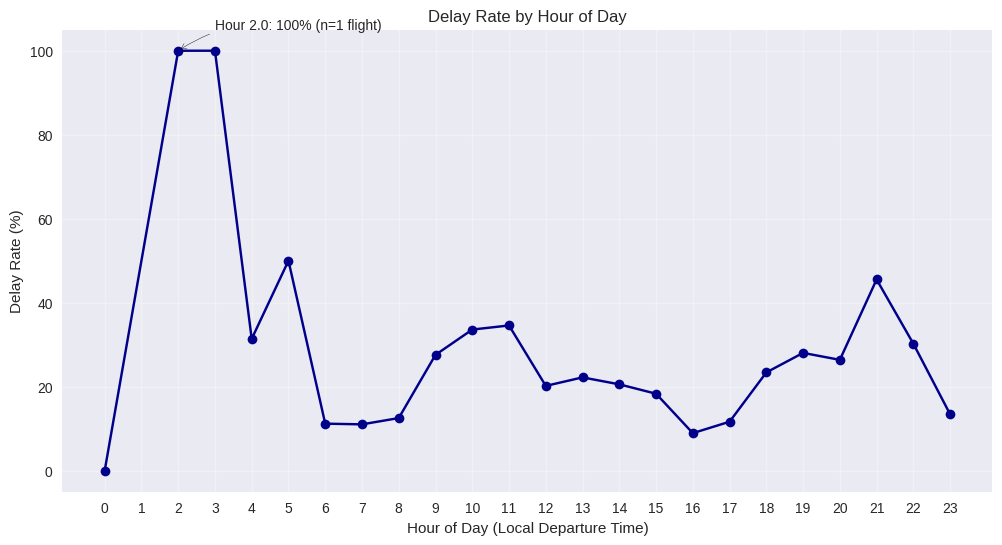

In [16]:

# Analyze delay rate by hour of the day
df['departure_hour'] = pd.to_datetime(df['sch_departure_lt']).dt.hour

hourly_delay = df.groupby('departure_hour')['is_delayed'].agg(['count', 'mean']).reset_index()
hourly_delay.columns = ['departure_hour', 'total_flights', 'delay_rate']
hourly_delay['delay_rate_pct'] = hourly_delay['delay_rate'] * 100

# Find the hour with 100% delay rate and only 1 flight
special_hour = hourly_delay[(hourly_delay['delay_rate_pct'] == 100) & (hourly_delay['total_flights'] == 1)]

plt.figure(figsize=(12, 6))
plt.plot(hourly_delay['departure_hour'], hourly_delay['delay_rate_pct'], marker='o', linestyle='-', color='darkblue')
plt.xlabel('Hour of Day (Local Departure Time)')
plt.ylabel('Delay Rate (%)')
plt.title('Delay Rate by Hour of Day')
plt.xticks(np.arange(0, 24, 1)) # Ensure all hours are shown on x-axis
plt.grid(True, alpha=0.3)

# Annotate the specific point if it exists
if not special_hour.empty:
    hour = special_hour.iloc[0]['departure_hour']
    flights = int(special_hour.iloc[0]['total_flights'])
    delay_rate = special_hour.iloc[0]['delay_rate_pct']
    plt.annotate(f'Hour {hour}: {delay_rate:.0f}% (n={flights} flight)',
                 xy=(hour, delay_rate), xycoords='data',
                 xytext=(hour + 1, delay_rate + 5), textcoords='data',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

plt.show()

## Excluding hours of the day which have less than 5 flights from our analysis

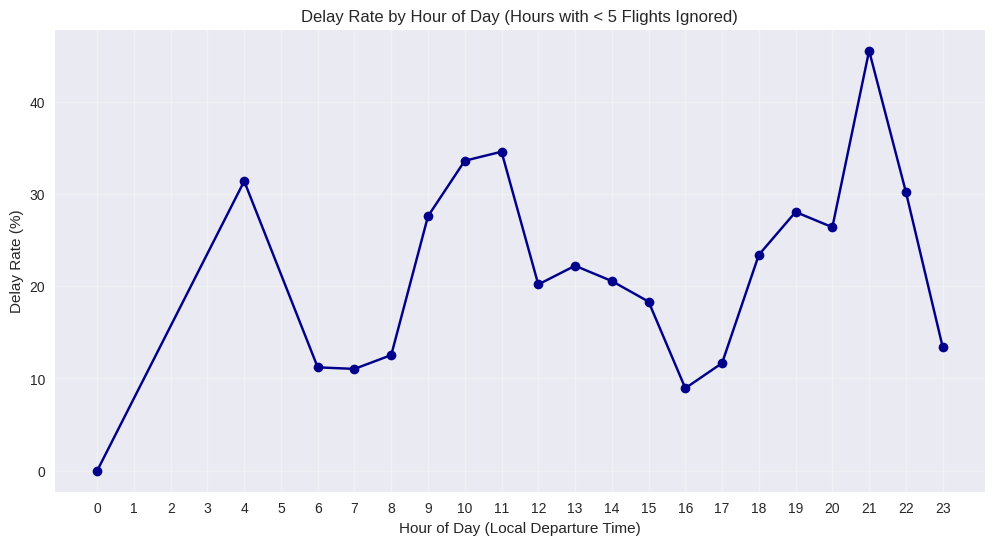


Table of Total Flights and Delay Rate by Hour:
 departure_hour  total_flights  delay_rate_pct
              0             10            0.00
              2              1          100.00
              3              1          100.00
              4             86           31.40
              5              2           50.00
              6            116           11.21
              7            933           11.04
              8            319           12.54
              9           1620           27.59
             10            244           33.61
             11            798           34.59
             12            307           20.20
             13            279           22.22
             14           1060           20.57
             15             60           18.33
             16            313            8.95
             17            780           11.67
             18           1491           23.41
             19           1105           28.05
            

In [17]:


# Analyze delay rate by hour of the day
df['departure_hour'] = pd.to_datetime(df['sch_departure_lt']).dt.hour

hourly_delay = df.groupby('departure_hour')['is_delayed'].agg(['count', 'mean']).reset_index()
hourly_delay.columns = ['departure_hour', 'total_flights', 'delay_rate']
hourly_delay['delay_rate_pct'] = hourly_delay['delay_rate'] * 100

# Filter out hours with less than 5 flights
hourly_delay_filtered = hourly_delay[hourly_delay['total_flights'] >= 5].copy()

plt.figure(figsize=(12, 6))
plt.plot(hourly_delay_filtered['departure_hour'], hourly_delay_filtered['delay_rate_pct'], marker='o', linestyle='-', color='darkblue')
plt.xlabel('Hour of Day (Local Departure Time)')
plt.ylabel('Delay Rate (%)')
plt.title('Delay Rate by Hour of Day (Hours with < 5 Flights Ignored)')
plt.xticks(np.arange(0, 24, 1)) # Ensure all hours are shown on x-axis
plt.grid(True, alpha=0.3)
plt.show()

print("\nTable of Total Flights and Delay Rate by Hour:")
print(hourly_delay[['departure_hour', 'total_flights', 'delay_rate_pct']].round(2).to_string(index=False))
print("\nNote: The plot excludes hours with less than 5 flights.")

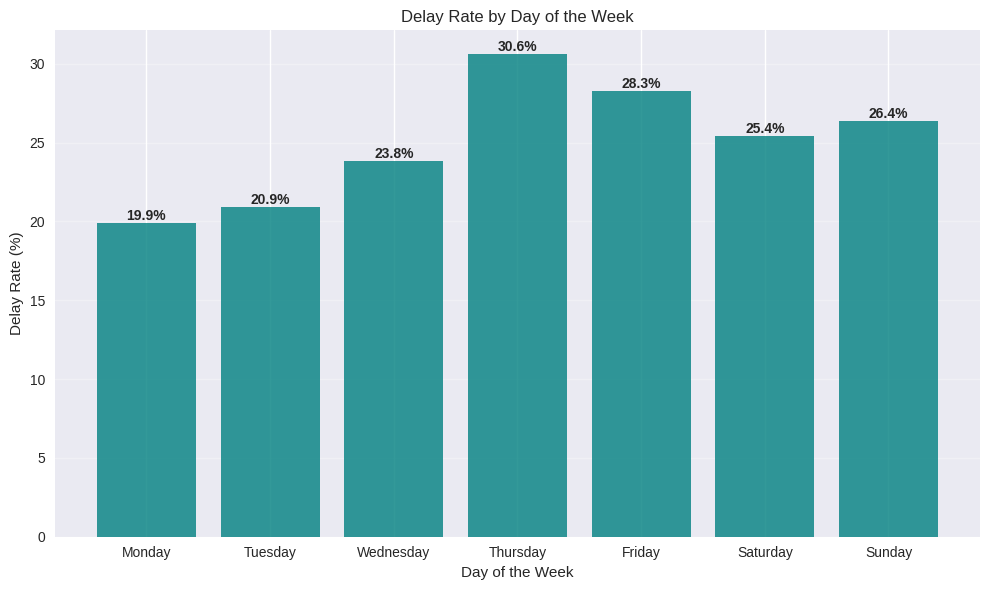


Table of Total Flights, Flight Percentage, and Delay Rate by Day of the Week:
day_of_week  total_flights  flight_percentage  delay_rate_pct
     Monday           1837              14.92           19.92
    Tuesday           1864              15.14           20.92
  Wednesday           1924              15.63           23.80
   Thursday           1824              14.82           30.59
     Friday           1798              14.60           28.25
   Saturday           1598              12.98           25.41
     Sunday           1466              11.91           26.40


In [60]:

# Analyze delay rate by day of the week
df['day_of_week'] = pd.to_datetime(df['sch_departure_lt']).dt.day_name()

# Calculate total flights and delayed flights by day of the week
daily_delay = df.groupby('day_of_week')['is_delayed'].agg(['count', 'sum', 'mean']).reset_index()
daily_delay.columns = ['day_of_week', 'total_flights', 'delayed_flights', 'delay_rate']
daily_delay['delay_rate_pct'] = daily_delay['delay_rate'] * 100

# Define the order of days of the week for plotting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_delay['day_of_week'] = pd.Categorical(daily_delay['day_of_week'], categories=day_order, ordered=True)
daily_delay = daily_delay.sort_values('day_of_week')

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(daily_delay['day_of_week'], daily_delay['delay_rate_pct'], color='teal', alpha=0.8)
plt.xlabel('Day of the Week')
plt.ylabel('Delay Rate (%)')
plt.title('Delay Rate by Day of the Week')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate percentage of total flights for each day
total_flights_overall = daily_delay['total_flights'].sum()
daily_delay['flight_percentage'] = (daily_delay['total_flights'] / total_flights_overall) * 100

print("\nTable of Total Flights, Flight Percentage, and Delay Rate by Day of the Week:")
print(daily_delay[['day_of_week', 'total_flights', 'flight_percentage', 'delay_rate_pct']].round(2).to_string(index=False))

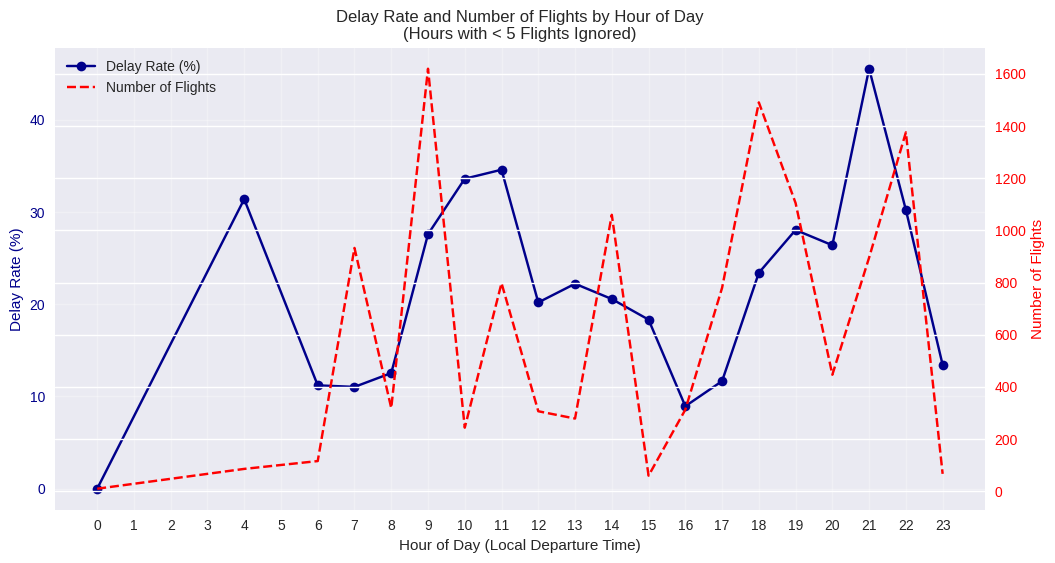


Table of Total Flights and Delay Rate by Hour:
 departure_hour  total_flights  delay_rate_pct
              0             10            0.00
              2              1          100.00
              3              1          100.00
              4             86           31.40
              5              2           50.00
              6            116           11.21
              7            933           11.04
              8            319           12.54
              9           1620           27.59
             10            244           33.61
             11            798           34.59
             12            307           20.20
             13            279           22.22
             14           1060           20.57
             15             60           18.33
             16            313            8.95
             17            780           11.67
             18           1491           23.41
             19           1105           28.05
            

In [19]:


# Analyze delay rate and number of flights by hour of the day
df['departure_hour'] = pd.to_datetime(df['sch_departure_lt']).dt.hour

hourly_stats = df.groupby('departure_hour')['is_delayed'].agg(['count', 'mean']).reset_index()
hourly_stats.columns = ['departure_hour', 'total_flights', 'delay_rate']
hourly_stats['delay_rate_pct'] = hourly_stats['delay_rate'] * 100

# Filter out hours with less than 5 flights
hourly_stats_filtered = hourly_stats[hourly_stats['total_flights'] >= 5].copy()

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Delay Rate on the first y-axis
ax1.plot(hourly_stats_filtered['departure_hour'], hourly_stats_filtered['delay_rate_pct'], marker='o', linestyle='-', color='darkblue', label='Delay Rate (%)')
ax1.set_xlabel('Hour of Day (Local Departure Time)')
ax1.set_ylabel('Delay Rate (%)', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')
ax1.grid(True, alpha=0.3)

# Create a second y-axis for Total Flights
ax2 = ax1.twinx()
ax2.plot(hourly_stats_filtered['departure_hour'], hourly_stats_filtered['total_flights'], marker='x', linestyle='--', color='red', label='Number of Flights')
ax2.set_ylabel('Number of Flights', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title and x-axis ticks
plt.title('Delay Rate and Number of Flights by Hour of Day\n(Hours with < 5 Flights Ignored)')
plt.xticks(np.arange(0, 24, 1)) # Ensure all hours are shown on x-axis

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')


plt.show()

print("\nTable of Total Flights and Delay Rate by Hour:")
print(hourly_stats[['departure_hour', 'total_flights', 'delay_rate_pct']].round(2).to_string(index=False))
print("\nNote: The plot excludes hours with less than 5 flights.")




4. CORRELATION ANALYSIS
Correlation with Delay:
  booked_passengers: 0.129
  distance: 0.098
  flight_minutes: 0.090
  total_number_of_bags: 0.087
  flt_capacity: -0.024


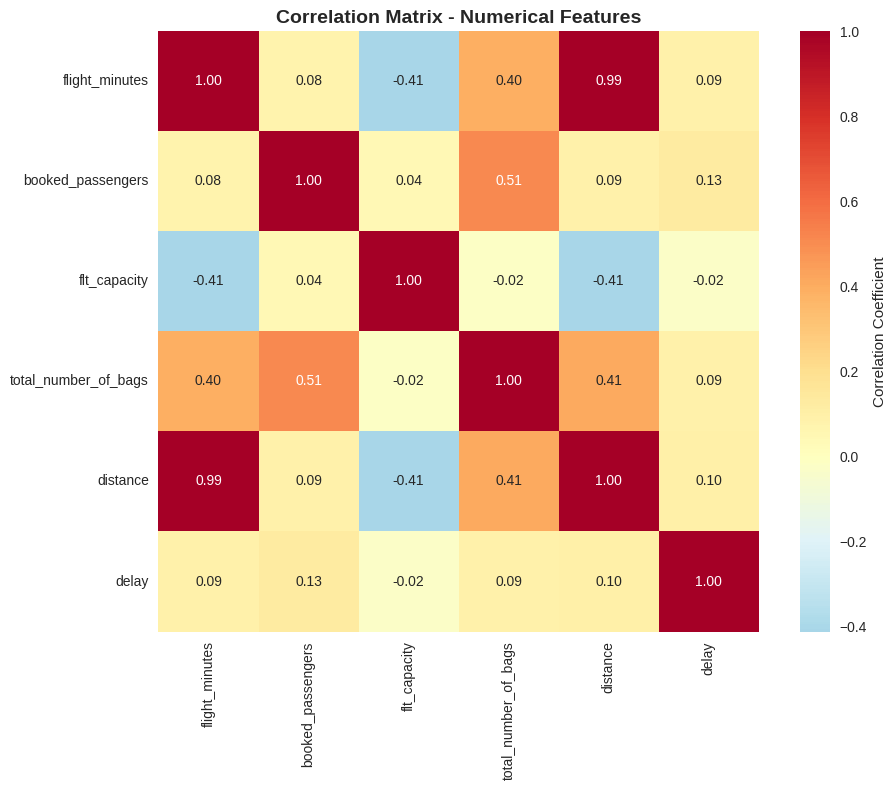

In [20]:

# ===================================================================
# 5. CORRELATION ANALYSIS
# ===================================================================

print("\n" + "=" * 60)
print("4. CORRELATION ANALYSIS")
print("=" * 60)

# Select numerical columns for correlation
numerical_cols = ['flight_minutes', 'booked_passengers', 'flt_capacity',
                 'total_number_of_bags', 'distance', 'delay',]

correlation_matrix = df[numerical_cols].corr()

print("Correlation with Delay:")
delay_corr = correlation_matrix['delay'].sort_values(ascending=False)
for col, corr in delay_corr.items():
    if col != 'delay':
        print(f"  {col}: {corr:.3f}")

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## **Creating A "Turnaround Time" Variable which is indicating that a lower turnaround time < 240 minutes leads to delays**

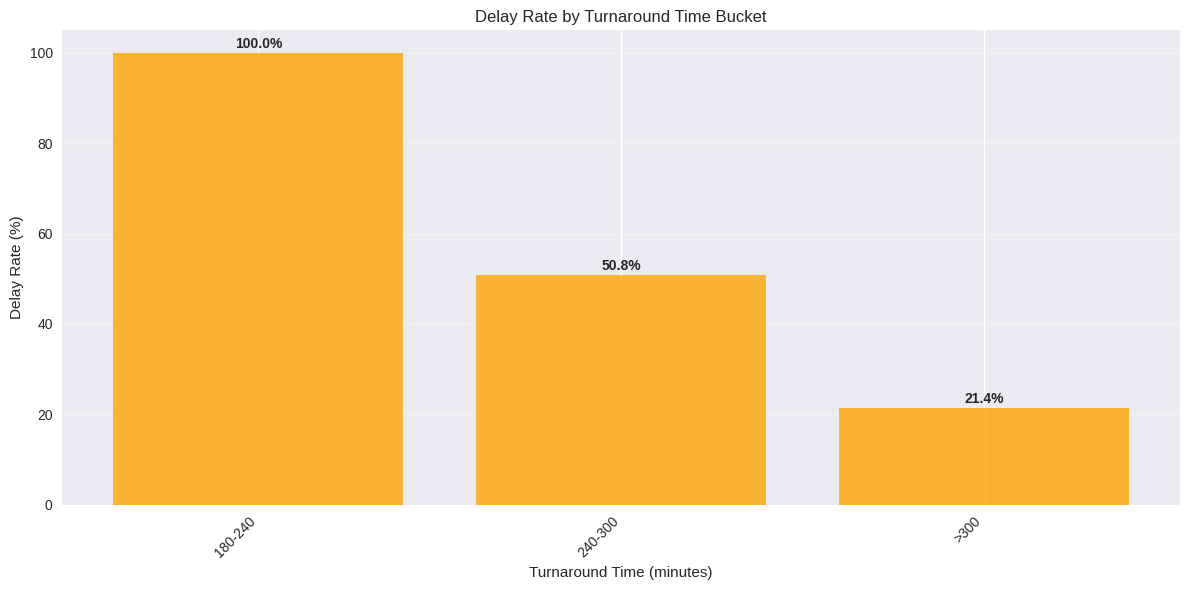


Table of Delay Rate by Turnaround Time Bucket:
turnaround_bucket  delay_rate_pct
              <30             NaN
            30-60             NaN
            60-90             NaN
           90-120             NaN
          120-180             NaN
          180-240          100.00
          240-300           50.82
             >300           21.36


In [26]:

df['turnaround_minutes'] = (df['sch_departure_lt'] - df['prev_flight_arrival']).dt.total_seconds() / 60
# Ensure 'turnaround_minutes' is not negative or zero for log scaling if needed
df['turnaround_minutes'] = df['turnaround_minutes'].apply(lambda x: x if x > 0 else 1)

# Create bins for 'turnaround_minutes'
bins = [0, 30, 60, 90, 120, 180, 240, 300, df['turnaround_minutes'].max()]
labels = ['<30', '30-60', '60-90', '90-120', '120-180', '180-240', '240-300', '>300']
df['turnaround_bucket'] = pd.cut(df['turnaround_minutes'], bins=bins, labels=labels, right=True, include_lowest=True)

# Calculate delay percentage per turnaround bucket
turnaround_delay_perc = df.groupby('turnaround_bucket')['is_delayed'].mean().reset_index()
turnaround_delay_perc['delay_rate_pct'] = turnaround_delay_perc['is_delayed'] * 100

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(turnaround_delay_perc['turnaround_bucket'], turnaround_delay_perc['delay_rate_pct'], color='orange', alpha=0.8)

plt.xlabel('Turnaround Time (minutes)')
plt.ylabel('Delay Rate (%)')
plt.title('Delay Rate by Turnaround Time Bucket')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nTable of Delay Rate by Turnaround Time Bucket:")
print(turnaround_delay_perc[['turnaround_bucket', 'delay_rate_pct']].round(2).to_string(index=False))

In [25]:
df['to_Region'].unique()

array(['CIS', 'ME', 'GCC', 'EU', 'AF'], dtype=object)

## Feature Engineering

In [38]:
############# Feature Engineering #################


def create_features(df):
    df = df.copy()
    # Convert datetime columns
    df['departure_date'] = pd.to_datetime(df['departure date'])
    df['sch_departure_local'] = pd.to_datetime(df['sch_departure_lt'])
    df['prev_arrival'] = pd.to_datetime(df['prev_flight_arrival'])


    # Target variable
    df['is_delayed'] = (df['delay'] > 15).astype(int)


    df['departure_hour'] = df['sch_departure_local'].dt.hour
    df['departure_day_of_week'] = df['sch_departure_local'].dt.dayofweek  # 0=Monday
    df['departure_month'] = df['sch_departure_local'].dt.month
    df['departure_day_of_month'] = df['sch_departure_local'].dt.day



    df['load_factor'] = df['booked_passengers'] / df['flt_capacity']
    df['bags_per_passenger'] = df['total_number_of_bags'] / df['booked_passengers'].replace(0, 1)

    df['load_factor'] = df['load_factor'].fillna(0)  # Fill NaNs with 0


    df['high_utilization'] = (df['load_factor'] > 0.9).astype(int)
    df['medium_utilization'] = ((df['load_factor'] > 0.7) & (df['load_factor'] <= 0.9)).astype(int)
    df['low_utilization'] = (df['load_factor'] <= 0.7).astype(int)

    regional_delay_rates = df.groupby('to_Region')['is_delayed'].mean()
    df['region_risk_score'] = df['to_Region'].map(regional_delay_rates)
    df['region_risk_score'].fillna(0, inplace=True)


    categorical_cols_low_cardinality = ['to_Region', 'terminal','aircraft']
    cols_to_encode = [col for col in categorical_cols_low_cardinality if col in df.columns]

    # Apply one-hot encoding
    df = pd.get_dummies(df, columns=cols_to_encode, prefix=cols_to_encode, dtype=int)


    # --- 4. Drop Original/Intermediate Date/Time Columns ---
    print("Dropping original/intermediate date/time columns...")
    columns_to_drop = [
                #not useful info
      'from_airport',        # only one from airport
      'sch_departure_lt',      # Original local time string
      'sch_departure_utc',     # Original UTC time string
      'prev_flight_arrival',   # Original previous arrival string
       'day_of_week'
    ]

    return df.drop(columns=columns_to_drop)



# Apply feature engineering
df_features = create_features(df)



print("Feature Engineering Complete!")
print(f"Original features: {df.shape[1]}")
print(f"Engineered features: {df_features.shape[1]}")
print(f"New features added: {df_features.shape[1] - df.shape[1]}")

# Display new features
new_features = [col for col in df_features.columns if col not in df.columns]
print(f"\nNew Features Created:")
for i, feature in enumerate(new_features, 1):
    print(f"  {i:2d}. {feature}")

# ===================================================================

Dropping original/intermediate date/time columns...
Feature Engineering Complete!
Original features: 26
Engineered features: 39
New features added: 13

New Features Created:
   1. departure_date
   2. sch_departure_local
   3. prev_arrival
   4. departure_day_of_week
   5. departure_month
   6. departure_day_of_month
   7. bags_per_passenger
   8. high_utilization
   9. medium_utilization
  10. low_utilization
  11. region_risk_score
  12. to_Region_AF
  13. to_Region_CIS
  14. to_Region_EU
  15. to_Region_GCC
  16. to_Region_ME
  17. terminal_Terminal 2
  18. terminal_Terminal 3
  19. aircraft_B737 MAX 8
  20. aircraft_B737 MAX 9
  21. aircraft_B737-800


In [40]:
# Check that all values are now bucketed
print("Load factor range:", df_features['load_factor'].min(), "to", df_features['load_factor'].max())
print("Utilization df_features:")
print(f"Low (≤0.7): {(df_features['load_factor'] <= 0.7).sum()}")
print(f"Medium (0.7-0.9): {((df_features['load_factor'] > 0.7) & (df_features['load_factor'] <= 0.9)).sum()}")
print(f"High (>0.9): {(df_features['load_factor'] > 0.9).sum()}")
print(f"Total: {len(df_features)}")

Load factor range: 0.030120481927710843 to 1.4195402298850575
Utilization df_features:
Low (≤0.7): 4013
Medium (0.7-0.9): 3286
High (>0.9): 5012
Total: 12311


In [41]:
print(5012 + 3286+ 4013 )

12311


In [42]:
df_features.isna().sum()

,0
Flight_ID,0
departure date,0
parking_bay,0
to_airport,0
gate_number,0
flight_minutes,0
booked_passengers,0
flt_capacity,0
prev_Airport,0
total_number_of_bags,0


In [37]:
df_features['to_airport'].unique()

array(['aaa', 'bbb', 'ccc', 'ddd', 'eee', 'fff', 'ggg', 'hhh', 'iii'],
      dtype=object)

In [43]:
pd.set_option('display.max_columns', None)
df_features.head(2)

,Flight_ID,departure date,parking_bay,to_airport,gate_number,flight_minutes,booked_passengers,flt_capacity,prev_Airport,total_number_of_bags,distance,delay,is_delayed,load_factor,utilization_bucket,departure_hour,turnaround_minutes,turnaround_bucket,departure_date,sch_departure_local,prev_arrival,departure_day_of_week,departure_month,departure_day_of_month,bags_per_passenger,high_utilization,medium_utilization,low_utilization,region_risk_score,to_Region_AF,to_Region_CIS,to_Region_EU,to_Region_GCC,to_Region_ME,terminal_Terminal 2,terminal_Terminal 3,aircraft_B737 MAX 8,aircraft_B737 MAX 9,aircraft_B737-800
0,F_1704,2023-01-30,C30,aaa,B2,248,177,174,111,199,2814,33,1,1.017241,NaN,21,350.0,>300,2023-01-30,2023-02-01 21:30:00,2023-02-01 15:40:00,2,2,1,1.124294,1,0,0,0.413793,0,1,0,0,0,0,1,0,0,1
1,F_1704,2023-02-10,C37,aaa,B3,236,157,174,112,175,2814,49,1,0.902299,High (>90%),21,260.0,240-300,2023-02-10,2023-02-12 21:30:00,2023-02-12 17:10:00,6,2,12,1.114650,1,0,0,0.413793,0,1,0,0,0,0,1,0,0,1


### Removing Datetime Columns and Columns with High Cardinality

In [44]:
datetime_cols = df_features.select_dtypes(include=['datetime64', 'datetime']).columns
df_features = df_features.drop(columns=datetime_cols)

y = df_features['is_delayed']
X = df_features.drop(columns=['is_delayed', 'delay','Flight_ID', 'parking_bay','to_airport', 'gate_number', 'prev_Airport','utilization_bucket','turnaround_bucket']) # Drop original delay too, as 'is_delayed' is the targeta
# and high cardinality columns

## Splitting the data as Train and Test

In [45]:

# --- 3. Split Data ---

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"\nData split into training and testing sets.")
print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Delay distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Delay distribution in testing set:\n{y_test.value_counts(normalize=True)}")


Data split into training and testing sets.
Training set shape: X_train: (9233, 26), y_train: (9233,)
Testing set shape: X_test: (3078, 26), y_test: (3078,)
Delay distribution in training set:
is_delayed
0    0.750352
1    0.249648
Name: proportion, dtype: float64
Delay distribution in testing set:
is_delayed
0    0.750487
1    0.249513
Name: proportion, dtype: float64


In [46]:
X_train.head(2)

,flight_minutes,booked_passengers,flt_capacity,total_number_of_bags,distance,load_factor,departure_hour,turnaround_minutes,departure_day_of_week,departure_month,departure_day_of_month,bags_per_passenger,high_utilization,medium_utilization,low_utilization,region_risk_score,to_Region_AF,to_Region_CIS,to_Region_EU,to_Region_GCC,to_Region_ME,terminal_Terminal 2,terminal_Terminal 3,aircraft_B737 MAX 8,aircraft_B737 MAX 9,aircraft_B737-800
10311,64,156,174,121,349,0.896552,22,360.0,1,10,22,0.775641,0,1,0,0.186524,0,0,0,1,0,1,0,1,0,0
8151,271,133,166,183,2969,0.801205,9,425.0,0,5,8,1.375940,0,1,0,0.255664,0,0,1,0,0,1,0,1,0,0


### Scaling the Numercial Features

In [47]:
X_train.columns

Index(['flight_minutes', 'booked_passengers', 'flt_capacity',
       'total_number_of_bags', 'distance', 'load_factor', 'departure_hour',
       'turnaround_minutes', 'departure_day_of_week', 'departure_month',
       'departure_day_of_month', 'bags_per_passenger', 'high_utilization',
       'medium_utilization', 'low_utilization', 'region_risk_score',
       'to_Region_AF', 'to_Region_CIS', 'to_Region_EU', 'to_Region_GCC',
       'to_Region_ME', 'terminal_Terminal 2', 'terminal_Terminal 3',
       'aircraft_B737 MAX 8', 'aircraft_B737 MAX 9', 'aircraft_B737-800'],
      dtype='object')

In [48]:
categorical_cols_low_cardinality = ['to_Region',
                                    'terminal',
                                    'to_Region_AF',
                                    'turnaround_bucket',
                                    'to_Region_CIS',
                                    'to_Region_EU',
                                    'to_Region_GCC',
                                    'to_Region_ME',
                                    'terminal_Terminal 2',
                                    'terminal_Terminal 3',
                                    'high_utilization',
                                    'medium_utilization',
                                    'departure_day_of_week',
                                    'departure_month',
                                    'departure_hour',
                                    'departure_day_of_month',
                                    'low_utilization',
                                    'aircraft_B737 MAX 8',
                                    'aircraft_B737 MAX 9',
                                    'aircraft_B737-800']
features_to_scale = [col for col in X_train.columns if col not in categorical_cols_low_cardinality ]
if features_to_scale:
    scaler = StandardScaler()
    X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])
    print(f"\nScaled {len(features_to_scale)} numerical features: {features_to_scale}")
else:
    print("\nNo features identified for scaling (or only binary/OHE features present).")



Scaled 9 numerical features: ['flight_minutes', 'booked_passengers', 'flt_capacity', 'total_number_of_bags', 'distance', 'load_factor', 'turnaround_minutes', 'bags_per_passenger', 'region_risk_score']


In [49]:
X_train.head(2)

,flight_minutes,booked_passengers,flt_capacity,total_number_of_bags,distance,load_factor,departure_hour,turnaround_minutes,departure_day_of_week,departure_month,departure_day_of_month,bags_per_passenger,high_utilization,medium_utilization,low_utilization,region_risk_score,to_Region_AF,to_Region_CIS,to_Region_EU,to_Region_GCC,to_Region_ME,terminal_Terminal 2,terminal_Terminal 3,aircraft_B737 MAX 8,aircraft_B737 MAX 9,aircraft_B737-800
10311,-1.137923,0.610723,0.418177,-0.447023,-1.136024,0.542113,22,-0.276071,1,10,22,-0.899599,0,1,0,-0.816879,0,0,0,1,0,1,0,1,0,0
8151,0.749309,-0.021362,-0.838055,0.534932,0.824022,0.092836,9,-0.110866,0,5,8,0.581826,0,1,0,0.068081,0,0,1,0,0,1,0,1,0,0


## Traininng A Baseline Random forest Model we can see that the model is Overfitting and also has a poor performace


Training RandomForestClassifier model...
Model training complete.

--- Model Evaluation ---

Training Set Evaluation:
Accuracy: 1.0000
ROC AUC Score: 1.0000
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6928
           1       1.00      1.00      1.00      2305

    accuracy                           1.00      9233
   macro avg       1.00      1.00      1.00      9233
weighted avg       1.00      1.00      1.00      9233


Testing Set Evaluation:
Accuracy: 0.7820
ROC AUC Score: 0.7553
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2310
           1       0.66      0.26      0.37       768

    accuracy                           0.78      3078
   macro avg       0.73      0.61      0.62      3078
weighted avg       0.76      0.78      0.74      3078


Confusion Matrix (Test):
[[2206  104]
 [ 567  201]]


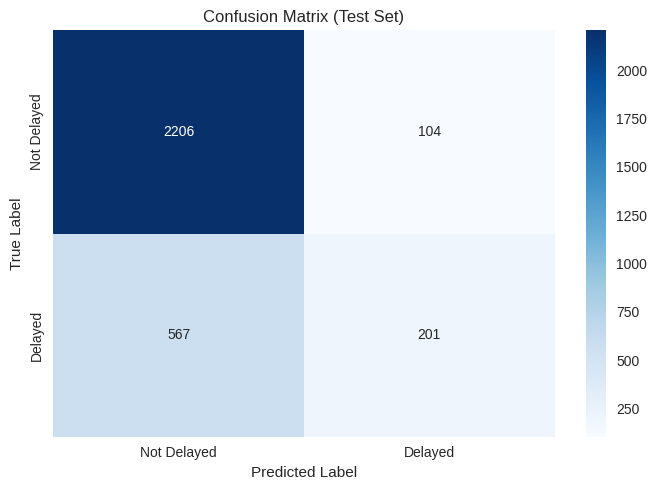

Displayed Confusion Matrix plot.

--- Top 15 Features by Importance (Random Forest) ---
                   Feature  Importance
7       turnaround_minutes    0.137823
0           flight_minutes    0.100975
11      bags_per_passenger    0.099183
3     total_number_of_bags    0.093602
5              load_factor    0.092920
1        booked_passengers    0.087820
10  departure_day_of_month    0.083066
9          departure_month    0.074703
6           departure_hour    0.054672
8    departure_day_of_week    0.053741
2             flt_capacity    0.019561
25       aircraft_B737-800    0.012324
4                 distance    0.012287
23     aircraft_B737 MAX 8    0.012230
15       region_risk_score    0.010823


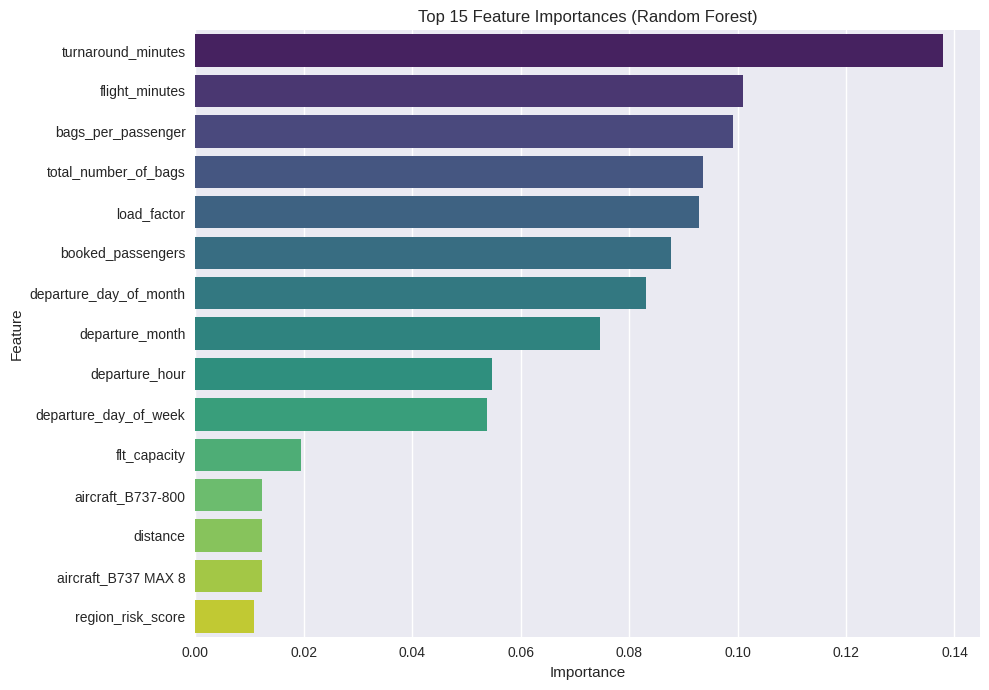

Displayed Top 15 Feature Importances plot.


In [50]:
# --- 5. Train RandomForestClassifier Model ---
print("\nTraining RandomForestClassifier model...")
# Using class_weight='balanced' to handle imbalance. n_estimators is a common hyperparameter.
model =RandomForestClassifier(n_estimators= 200,
                              min_samples_split= 2,
                              max_depth= None,
                              class_weight= 'balanced')


model.fit(X_train, y_train)
print("Model training complete.")

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]



print("\n--- Model Evaluation ---")

print("\nTraining Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]):.4f}")
print("Classification Report (Train):")
print(classification_report(y_train, y_pred_train, zero_division=0))

print("\nTesting Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
if y_pred_proba_test is not None: # Should always be true for RandomForest
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_test):.4f}")
print("Classification Report (Test):")
print(classification_report(y_test, y_pred_test, zero_division=0))

print("\nConfusion Matrix (Test):")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

plt.figure(figsize=(7, 5)) # Adjusted size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Delayed', 'Delayed'], yticklabels=['Not Delayed', 'Delayed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()
print("Displayed Confusion Matrix plot.")

# --- Feature Importance (for RandomForestClassifier) ---
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\n--- Top 15 Features by Importance (Random Forest) ---")
    print(feature_importance_df.head(15))

    plt.figure(figsize=(10, 7)) # Adjusted size
    top_n = 15
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette="viridis")
    plt.title(f'Top {top_n} Feature Importances (Random Forest)')
    plt.tight_layout()
    plt.show()
    print(f"Displayed Top {top_n} Feature Importances plot.")
else:
    print("Could not retrieve feature importances from the model.")

### **Since Our Dataset has only 25% of Positive Class we need to apply class imbalance techniques like SMOTE to overcome this and improve performance**

In [51]:
# --- 5. Apply SMOTE to the Training Data ---
print("\nApplying SMOTE to the training data...")
smote = SMOTE(
    sampling_strategy=0.7,  # Instead of 1.0 (perfect balance)
    k_neighbors=3,          # Reduce from default 5
    random_state=42
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Training set shape after SMOTE: {X_train_smote.shape}")
print(f"Class distribution in training set after SMOTE:\n{pd.Series(y_train_smote).value_counts(normalize=True)}")



Applying SMOTE to the training data...
Training set shape after SMOTE: (11777, 26)
Class distribution in training set after SMOTE:
is_delayed
0    0.588265
1    0.411735
Name: proportion, dtype: float64



Training RandomForestClassifier model...
Model training complete.

--- Model Evaluation ---

Training Set (SMOTE'd) Evaluation:
Accuracy: 1.0000
ROC AUC Score: 1.0000
Classification Report (Train SMOTE'd):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6928
           1       1.00      1.00      1.00      4849

    accuracy                           1.00     11777
   macro avg       1.00      1.00      1.00     11777
weighted avg       1.00      1.00      1.00     11777


Testing Set Evaluation:
Accuracy: 0.7788
ROC AUC Score: 0.7550
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      2310
           1       0.58      0.40      0.47       768

    accuracy                           0.78      3078
   macro avg       0.70      0.65      0.67      3078
weighted avg       0.76      0.78      0.76      3078


Confusion Matrix (Test):
[[2093  217]
 [ 464

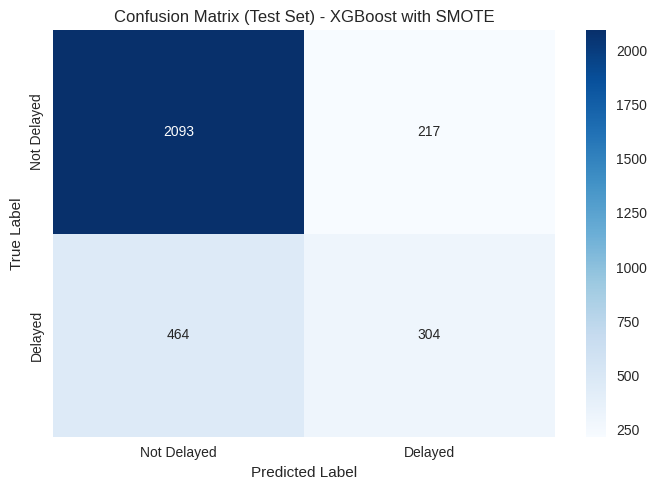

Displayed Confusion Matrix plot.

--- Top 15 Features by Importance (XGBoost) ---
                   Feature  Importance
7       turnaround_minutes    0.121143
0           flight_minutes    0.094277
5              load_factor    0.087217
1        booked_passengers    0.084569
11      bags_per_passenger    0.084372
3     total_number_of_bags    0.083578
10  departure_day_of_month    0.075428
9          departure_month    0.065055
6           departure_hour    0.050436
8    departure_day_of_week    0.047411
2             flt_capacity    0.036629
14         low_utilization    0.023637
25       aircraft_B737-800    0.020162
4                 distance    0.019104
23     aircraft_B737 MAX 8    0.018522


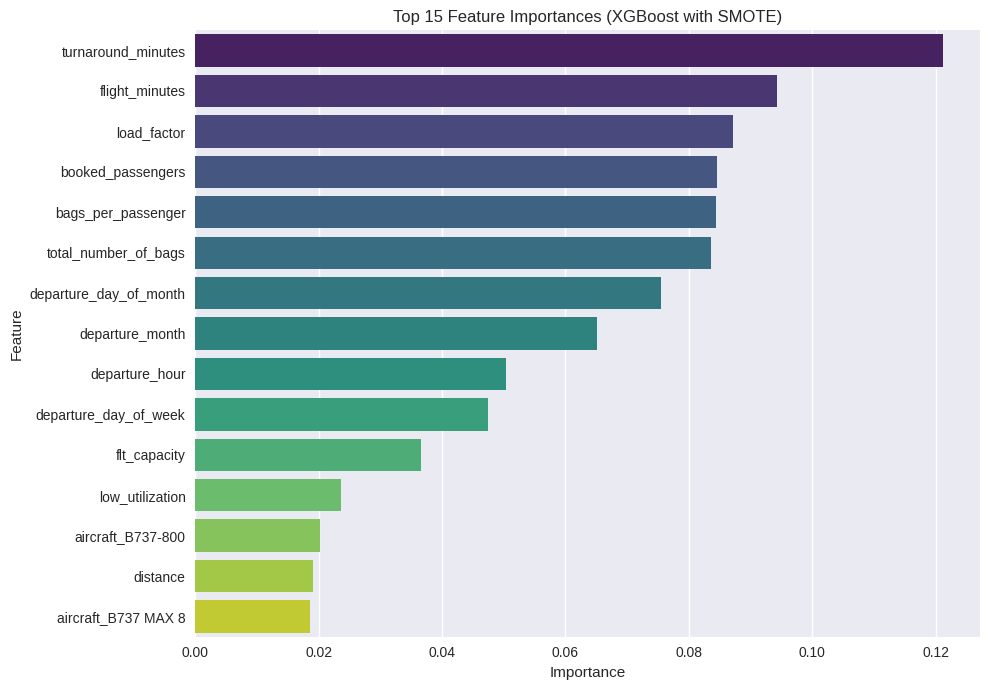

Displayed Top 15 Feature Importances plot.


In [52]:
print("\nTraining RandomForestClassifier model...")
# Using class_weight='balanced' to handle imbalance. n_estimators is a common hyperparameter.
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)


model.fit(X_train_smote, y_train_smote) # Train on SMOTE'd data
print("Model training complete.")

# --- 7. Make Predictions ---
# Predictions on original training set (before SMOTE) can be insightful for overfitting check,
# but primary evaluation is on test set.
y_pred_train_smote = model.predict(X_train_smote) # Predictions on the data it was trained on
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

# --- 8. Evaluate Model ---
print("\n--- Model Evaluation ---")

print("\nTraining Set (SMOTE'd) Evaluation:")
print(f"Accuracy: {accuracy_score(y_train_smote, y_pred_train_smote):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_train_smote, model.predict_proba(X_train_smote)[:, 1]):.4f}")
print("Classification Report (Train SMOTE'd):")
print(classification_report(y_train_smote, y_pred_train_smote, zero_division=0))

print("\nTesting Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
if y_pred_proba_test is not None:
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_test):.4f}")
print("Classification Report (Test):")
print(classification_report(y_test, y_pred_test, zero_division=0))

print("\nConfusion Matrix (Test):")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Delayed', 'Delayed'], yticklabels=['Not Delayed', 'Delayed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set) - XGBoost with SMOTE')
plt.tight_layout()
plt.show()
print("Displayed Confusion Matrix plot.")

# --- Feature Importance (for XGBoost) ---
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = X.columns # Use columns from X_processed (before train/test split)
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\n--- Top 15 Features by Importance (XGBoost) ---")
    print(feature_importance_df.head(15))

    plt.figure(figsize=(10, 7))
    top_n = 15
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette="viridis")
    plt.title(f'Top {top_n} Feature Importances (XGBoost with SMOTE)')
    plt.tight_layout()
    plt.show()
    print(f"Displayed Top {top_n} Feature Importances plot.")
else:
    print("Could not retrieve feature importances from the model.")


## **Even After Applying SMOTE RandomForest Classifer Did not Give us good results So we can try other models like XGboost**

Model training complete.

--- Model Evaluation ---

Training Set Evaluation:
Accuracy: 0.7809
ROC AUC Score: 0.8799
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      6928
           1       0.54      0.82      0.65      2305

    accuracy                           0.78      9233
   macro avg       0.73      0.79      0.75      9233
weighted avg       0.83      0.78      0.79      9233


Testing Set Evaluation:
Accuracy: 0.7170
ROC AUC Score: 0.7746
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.87      0.73      0.79      2310
           1       0.46      0.68      0.54       768

    accuracy                           0.72      3078
   macro avg       0.66      0.70      0.67      3078
weighted avg       0.77      0.72      0.73      3078


Confusion Matrix (Test):
[[1686  624]
 [ 247  521]]


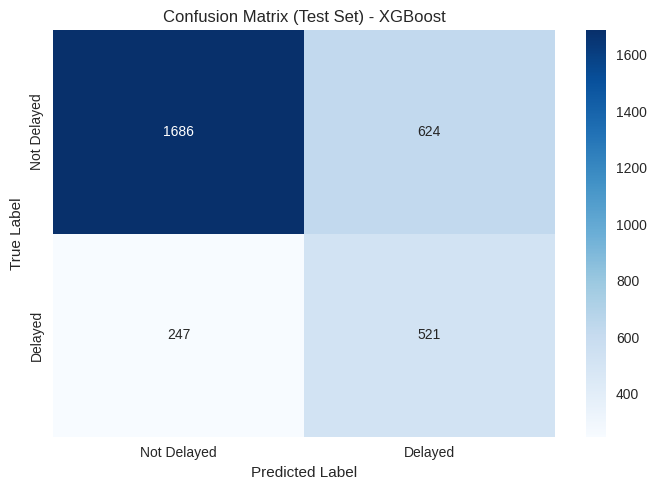

Displayed Confusion Matrix plot.

--- Top 15 Features by Importance (XGBoost) ---
                  Feature  Importance
21    terminal_Terminal 2    0.160668
22    terminal_Terminal 3    0.106062
7      turnaround_minutes    0.075945
23    aircraft_B737 MAX 8    0.063235
6          departure_hour    0.054963
5             load_factor    0.045976
0          flight_minutes    0.043807
4                distance    0.042956
9         departure_month    0.042814
18           to_Region_EU    0.042165
1       booked_passengers    0.041618
20           to_Region_ME    0.037328
25      aircraft_B737-800    0.031272
24    aircraft_B737 MAX 9    0.028831
8   departure_day_of_week    0.028542


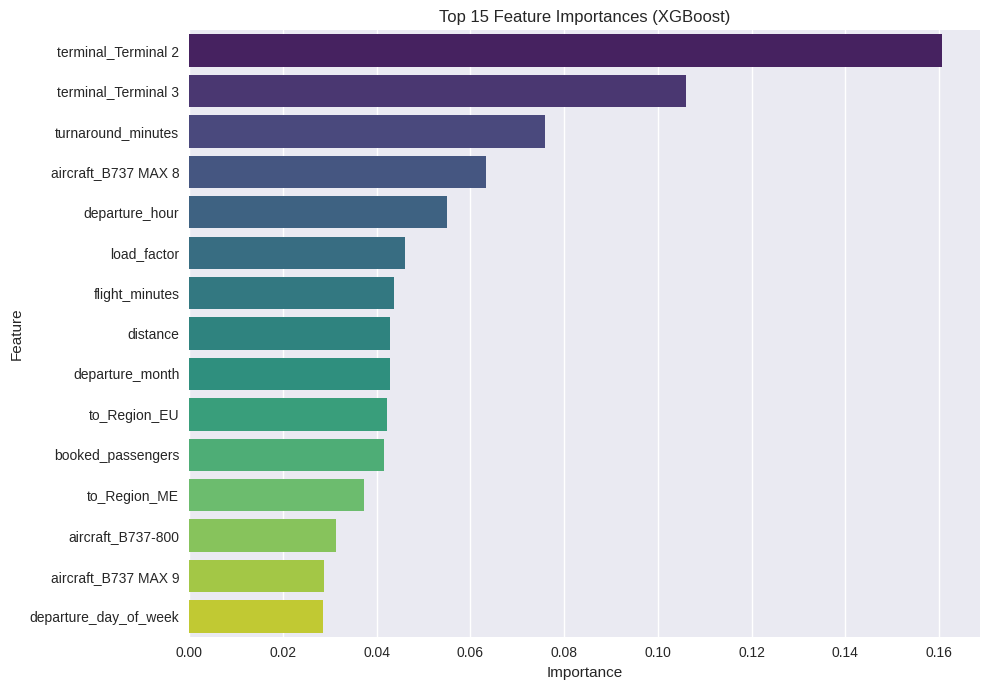

Displayed Top 15 Feature Importances plot.


In [53]:
# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

model = XGBClassifier(
    scale_pos_weight=class_weights[1]/class_weights[0],
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train, y_train)
print("Model training complete.")

# --- 7. Make Predictions ---
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

# --- 8. Evaluate Model ---
print("\n--- Model Evaluation ---")

print("\nTraining Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]):.4f}")
print("Classification Report (Train):")
print(classification_report(y_train, y_pred_train, zero_division=0))

print("\nTesting Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
if y_pred_proba_test is not None:
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_test):.4f}")
print("Classification Report (Test):")
print(classification_report(y_test, y_pred_test, zero_division=0))

print("\nConfusion Matrix (Test):")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Delayed', 'Delayed'], yticklabels=['Not Delayed', 'Delayed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set) - XGBoost')
plt.tight_layout()
plt.show()
print("Displayed Confusion Matrix plot.")

# --- Feature Importance (for XGBoost) ---
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = X.columns # Use columns from X_processed (before train/test split)
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\n--- Top 15 Features by Importance (XGBoost) ---")
    print(feature_importance_df.head(15))

    plt.figure(figsize=(10, 7))
    top_n = 15
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette="viridis")
    plt.title(f'Top {top_n} Feature Importances (XGBoost)')
    plt.tight_layout()
    plt.show()
    print(f"Displayed Top {top_n} Feature Importances plot.")
else:
    print("Could not retrieve feature importances from the model.")

In [ ]:
scale_pos_weight=class_weights[1]/class_weights[0]


Applying SMOTE to the training data...
Training set shape after SMOTE: (11777, 26)
Class distribution in training set after SMOTE:
is_delayed
0    0.588265
1    0.411735
Name: proportion, dtype: float64
Model training complete.

--- Model Evaluation ---

Training Set (SMOTE'd) Evaluation:
Accuracy: 0.7728
ROC AUC Score: 0.9188
Classification Report (Train SMOTE'd):
              precision    recall  f1-score   support

           0       0.94      0.65      0.77      6928
           1       0.66      0.94      0.77      4849

    accuracy                           0.77     11777
   macro avg       0.80      0.80      0.77     11777
weighted avg       0.82      0.77      0.77     11777


Testing Set Evaluation:
Accuracy: 0.6676
ROC AUC Score: 0.7735
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.89      0.63      0.74      2310
           1       0.41      0.78      0.54       768

    accuracy                           0.67   

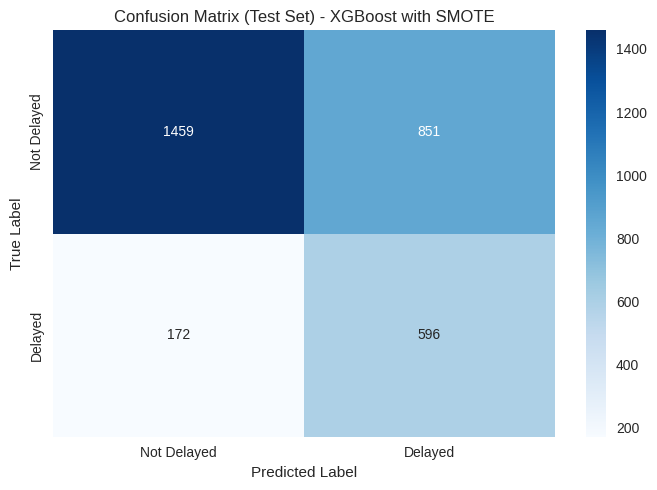

Displayed Confusion Matrix plot.

--- Top 15 Features by Importance (XGBoost) ---
                Feature  Importance
14      low_utilization    0.269005
12     high_utilization    0.168340
21  terminal_Terminal 2    0.087332
25    aircraft_B737-800    0.057546
24  aircraft_B737 MAX 9    0.051741
13   medium_utilization    0.050827
22  terminal_Terminal 3    0.045581
23  aircraft_B737 MAX 8    0.041468
2          flt_capacity    0.033002
7    turnaround_minutes    0.023945
6        departure_hour    0.022712
0        flight_minutes    0.016766
9       departure_month    0.016750
4              distance    0.014996
20         to_Region_ME    0.014421


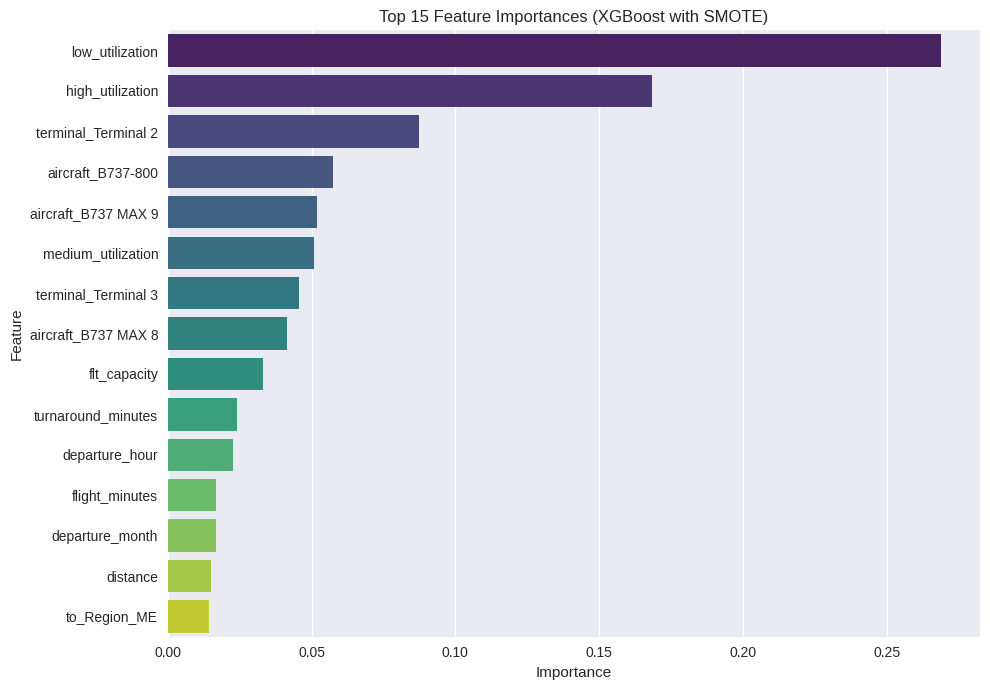

Displayed Top 15 Feature Importances plot.


In [55]:
# --- 5. Apply SMOTE to the Training Data ---
print("\nApplying SMOTE to the training data...")
smote = SMOTE(
    sampling_strategy=0.7,  # Instead of 1.0 (perfect balance)
    k_neighbors=3,          # Reduce from default 5
    random_state=42
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Training set shape after SMOTE: {X_train_smote.shape}")
print(f"Class distribution in training set after SMOTE:\n{pd.Series(y_train_smote).value_counts(normalize=True)}")


# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

model = XGBClassifier(
    scale_pos_weight=class_weights[1]/class_weights[0],
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train_smote, y_train_smote) # Train on SMOTE'd data
print("Model training complete.")

# --- 7. Make Predictions ---
# Predictions on original training set (before SMOTE) can be insightful for overfitting check,
# but primary evaluation is on test set.
y_pred_train_smote = model.predict(X_train_smote) # Predictions on the data it was trained on
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

# --- 8. Evaluate Model ---
print("\n--- Model Evaluation ---")

print("\nTraining Set (SMOTE'd) Evaluation:")
print(f"Accuracy: {accuracy_score(y_train_smote, y_pred_train_smote):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_train_smote, model.predict_proba(X_train_smote)[:, 1]):.4f}")
print("Classification Report (Train SMOTE'd):")
print(classification_report(y_train_smote, y_pred_train_smote, zero_division=0))

print("\nTesting Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
if y_pred_proba_test is not None:
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_test):.4f}")
print("Classification Report (Test):")
print(classification_report(y_test, y_pred_test, zero_division=0))

print("\nConfusion Matrix (Test):")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Delayed', 'Delayed'], yticklabels=['Not Delayed', 'Delayed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set) - XGBoost with SMOTE')
plt.tight_layout()
plt.show()
print("Displayed Confusion Matrix plot.")

# --- Feature Importance (for XGBoost) ---
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = X.columns # Use columns from X_processed (before train/test split)
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\n--- Top 15 Features by Importance (XGBoost) ---")
    print(feature_importance_df.head(15))

    plt.figure(figsize=(10, 7))
    top_n = 15
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette="viridis")
    plt.title(f'Top {top_n} Feature Importances (XGBoost with SMOTE)')
    plt.tight_layout()
    plt.show()
    print(f"Displayed Top {top_n} Feature Importances plot.")
else:
    print("Could not retrieve feature importances from the model.")


### Removing the Terminal variable

In [56]:


X_changed = X.drop(columns=['terminal_Terminal 3', 'terminal_Terminal 2'])

In [57]:


# --- 3. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X_changed, y, test_size=0.25, random_state=42, stratify=y)
print(f"\nData split into training and testing sets.")
print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Delay distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Delay distribution in testing set:\n{y_test.value_counts(normalize=True)}")


Data split into training and testing sets.
Training set shape: X_train: (9233, 24), y_train: (9233,)
Testing set shape: X_test: (3078, 24), y_test: (3078,)
Delay distribution in training set:
is_delayed
0    0.750352
1    0.249648
Name: proportion, dtype: float64
Delay distribution in testing set:
is_delayed
0    0.750487
1    0.249513
Name: proportion, dtype: float64


In [58]:
categorical_cols_low_cardinality = ['to_Region', 'terminal',]
features_to_scale = [col for col in X_train.columns if col not in categorical_cols_low_cardinality ]
if features_to_scale:
    scaler = StandardScaler()
    X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])
    print(f"\nScaled {len(features_to_scale)} numerical features: {features_to_scale}")
else:
    print("\nNo features identified for scaling (or only binary/OHE features present).")


Scaled 24 numerical features: ['flight_minutes', 'booked_passengers', 'flt_capacity', 'total_number_of_bags', 'distance', 'load_factor', 'departure_hour', 'turnaround_minutes', 'departure_day_of_week', 'departure_month', 'departure_day_of_month', 'bags_per_passenger', 'high_utilization', 'medium_utilization', 'low_utilization', 'region_risk_score', 'to_Region_AF', 'to_Region_CIS', 'to_Region_EU', 'to_Region_GCC', 'to_Region_ME', 'aircraft_B737 MAX 8', 'aircraft_B737 MAX 9', 'aircraft_B737-800']



Applying SMOTE to the training data...
Training set shape after SMOTE: (11777, 24)
Class distribution in training set after SMOTE:
is_delayed
0    0.588265
1    0.411735
Name: proportion, dtype: float64
Model training complete.

--- Model Evaluation ---

Training Set (SMOTE'd) Evaluation:
Accuracy: 0.7660
ROC AUC Score: 0.9248
Classification Report (Train SMOTE'd):
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      6928
           1       0.65      0.94      0.77      4849

    accuracy                           0.77     11777
   macro avg       0.79      0.79      0.77     11777
weighted avg       0.82      0.77      0.77     11777


Testing Set Evaluation:
Accuracy: 0.6543
ROC AUC Score: 0.7712
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.89      0.62      0.73      2310
           1       0.40      0.76      0.52       768

    accuracy                           0.65   

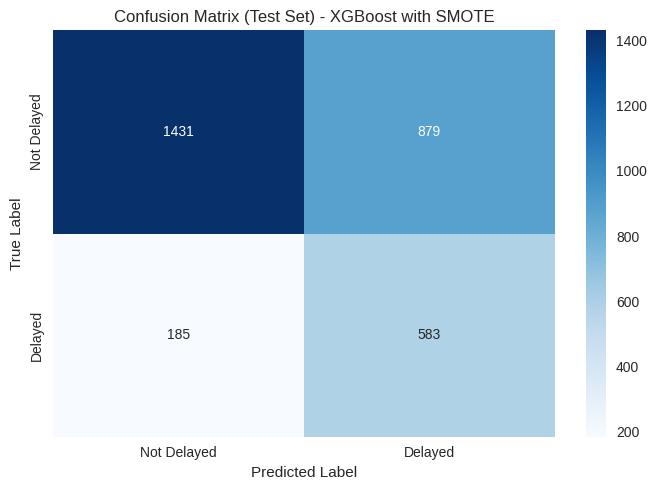

Displayed Confusion Matrix plot.

--- Top 15 Features by Importance (XGBoost) ---
                  Feature  Importance
14        low_utilization    0.273196
8   departure_day_of_week    0.071504
4                distance    0.058348
21    aircraft_B737 MAX 8    0.057026
17          to_Region_CIS    0.050335
7      turnaround_minutes    0.044471
6          departure_hour    0.043942
9         departure_month    0.043739
5             load_factor    0.042377
18           to_Region_EU    0.038723
23      aircraft_B737-800    0.038223
0          flight_minutes    0.035647
15      region_risk_score    0.033315
20           to_Region_ME    0.028837
1       booked_passengers    0.026438


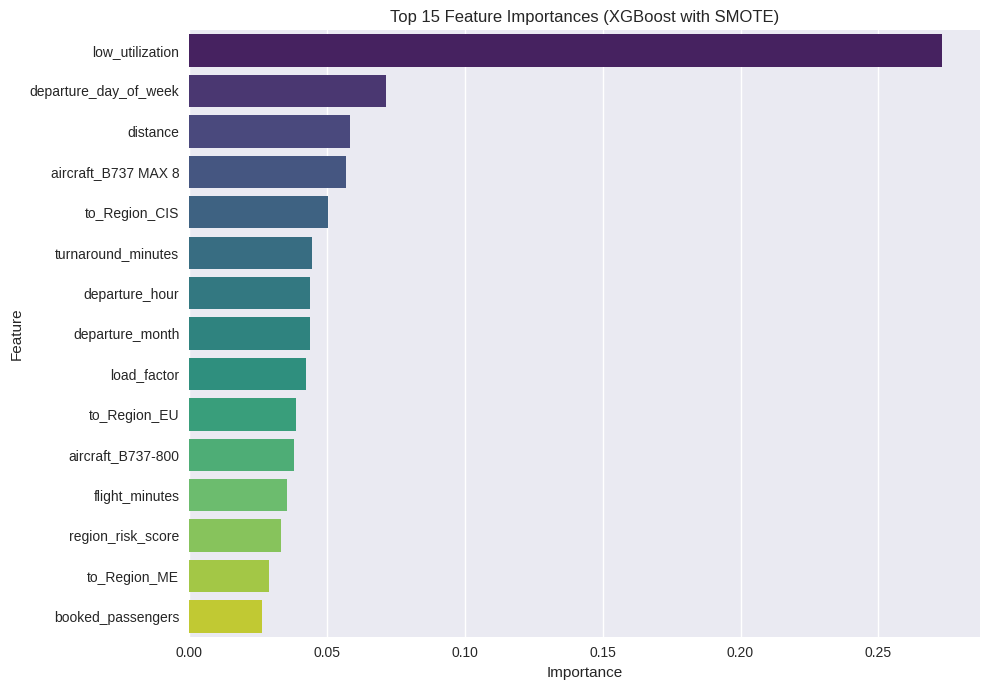

Displayed Top 15 Feature Importances plot.


In [59]:
# --- 5. Apply SMOTE to the Training Data ---
print("\nApplying SMOTE to the training data...")
smote = SMOTE(
    sampling_strategy=0.7,  # Instead of 1.0 (perfect balance)
    k_neighbors=3,          # Reduce from default 5
    random_state=42
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Training set shape after SMOTE: {X_train_smote.shape}")
print(f"Class distribution in training set after SMOTE:\n{pd.Series(y_train_smote).value_counts(normalize=True)}")


# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

model = XGBClassifier(
    scale_pos_weight=class_weights[1]/class_weights[0],
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train_smote, y_train_smote) # Train on SMOTE'd data
print("Model training complete.")

# --- 7. Make Predictions ---
# Predictions on original training set (before SMOTE) can be insightful for overfitting check,
# but primary evaluation is on test set.
y_pred_train_smote = model.predict(X_train_smote) # Predictions on the data it was trained on
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

# --- 8. Evaluate Model ---
print("\n--- Model Evaluation ---")

print("\nTraining Set (SMOTE'd) Evaluation:")
print(f"Accuracy: {accuracy_score(y_train_smote, y_pred_train_smote):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_train_smote, model.predict_proba(X_train_smote)[:, 1]):.4f}")
print("Classification Report (Train SMOTE'd):")
print(classification_report(y_train_smote, y_pred_train_smote, zero_division=0))

print("\nTesting Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
if y_pred_proba_test is not None:
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_test):.4f}")
print("Classification Report (Test):")
print(classification_report(y_test, y_pred_test, zero_division=0))

print("\nConfusion Matrix (Test):")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Delayed', 'Delayed'], yticklabels=['Not Delayed', 'Delayed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set) - XGBoost with SMOTE')
plt.tight_layout()
plt.show()
print("Displayed Confusion Matrix plot.")

# --- Feature Importance (for XGBoost) ---
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = X_changed.columns # Use columns from X_processed (before train/test split)
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\n--- Top 15 Features by Importance (XGBoost) ---")
    print(feature_importance_df.head(15))

    plt.figure(figsize=(10, 7))
    top_n = 15
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette="viridis")
    plt.title(f'Top {top_n} Feature Importances (XGBoost with SMOTE)')
    plt.tight_layout()
    plt.show()
    print(f"Displayed Top {top_n} Feature Importances plot.")
else:
    print("Could not retrieve feature importances from the model.")


**Performing K-Fold Cross Validation To Verify Model Robustness**


--- K-Fold Cross Validation ---
Cross-Validation Accuracy Scores: [0.7147708  0.7139219  0.72908705 0.7044586  0.7104034 ]
Mean CV Accuracy: 0.7145 (+/- 0.0163)
Cross-Validation ROC AUC Scores: [0.86517234 0.86391455 0.85676089 0.85393055 0.86290148]
Mean CV ROC AUC: 0.8605 (+/- 0.0088)


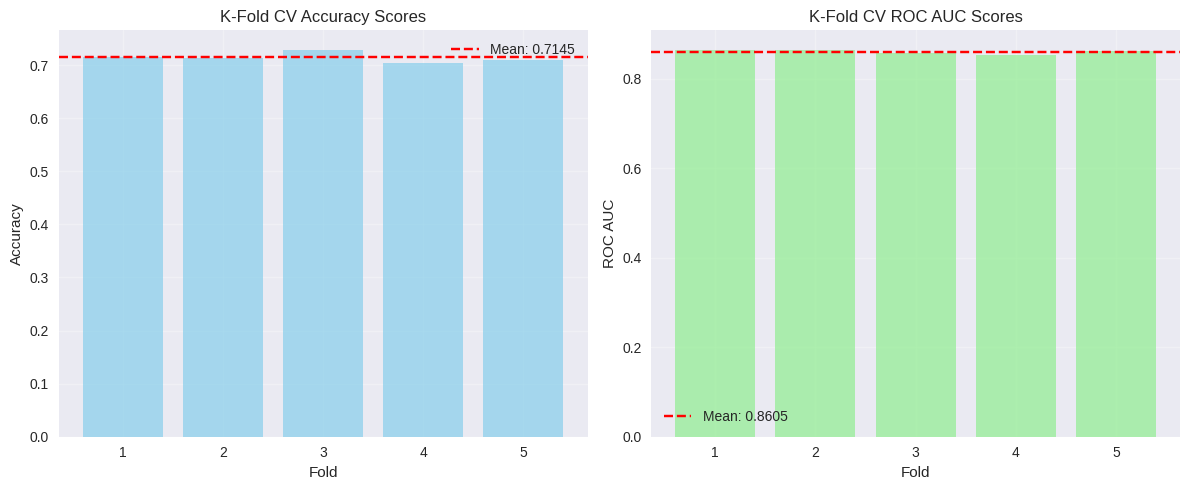

Displayed K-Fold Cross Validation plots.


In [ ]:
# --- K-Fold Cross Validation ---
print("\n--- K-Fold Cross Validation ---")
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Create stratified k-fold to maintain class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a fresh model for CV (same parameters as your original)
cv_model = XGBClassifier(
    scale_pos_weight=class_weights[1]/class_weights[0],
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Perform cross-validation on SMOTE'd data
cv_scores = cross_val_score(cv_model, X_train_smote, y_train_smote,
                           cv=cv, scoring='accuracy', n_jobs=-1)

cv_roc_scores = cross_val_score(cv_model, X_train_smote, y_train_smote,
                               cv=cv, scoring='roc_auc', n_jobs=-1)

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print(f"Cross-Validation ROC AUC Scores: {cv_roc_scores}")
print(f"Mean CV ROC AUC: {cv_roc_scores.mean():.4f} (+/- {cv_roc_scores.std() * 2:.4f})")

# Optional: Plot CV scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(cv_scores) + 1), cv_scores, alpha=0.7, color='skyblue')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('K-Fold CV Accuracy Scores')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, len(cv_roc_scores) + 1), cv_roc_scores, alpha=0.7, color='lightgreen')
plt.axhline(y=cv_roc_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_roc_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('K-Fold CV ROC AUC Scores')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("Displayed K-Fold Cross Validation plots.")

# Outcomes

By using SMOTE along with class weights for the XGboost model we were able to achieve a recall of 0.78

Our class weight approach achieved our primary objective: detecting 78% of actual delays

Next Steps:

Since we have a 60% false alarm rate we need to optimize for Precision while maitning recall in our next models and Also consider additional data sources like Historical Weather data

## Deployment and Monitoring Plan

###Real-Time Prediction System
Architecture:

Batch Processing: Daily model retraining with new data

Real-Time Inference: API for on-demand predictions

Feature Pipeline: Automated feature engineering from operational systems


###Monitoring Framework

Model Performance:
Daily Accuracy Tracking: Compare predictions vs actual outcomes

Drift Detection: Monitor feature distribution changes

Threshold Alerts: Notify when performance degrades